## One Cell Gas-Liquid Flow Model
$$ A_{g} \rightarrow A_{l} $$
$$ A_{l} + B_{l} \rightarrow C_{l} $$

In [209]:
using DifferentialEquations, Plots, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14068221612309110623\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15341095066358531572\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14068221612309110623\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Mass Balance BCM differential volume
### Solve first for 1 cell, then couple multiple cells in series

* **IN_Liq:** $$Fin·Cin + kla·(\frac{pi}{He} - C_{L,i})·V_{L}$$
* **OUT_liq:** $$Fout·C$$
* **Generation:** $$k·[A]·[B]·V_{L}$$
* **Accumulation:** $$\frac{\mathrm{d} (V_{L}·C_{i}) }{\mathrm{d} t} = V_{L}\frac{\mathrm{d} (C_{i}) }{\mathrm{d} t} + C_{i}\frac{\mathrm{d} (V_{L}) }{\mathrm{d} t}$$

In [210]:
const P = 1.0 # bar
const R = 8.314e-2 # L·bar /(K·mol)
const T = 273.15 # K


const Vcell = 0.5 # l 
const rho_liq = 1.0 # kg/l
const mw_A = 36.5e-3 # kg/mol

const Gin  = 3.0 # Nl/min inlet flowrate of gas
const Fin  = 0.1 # l/min inlet flowrate of liquid

const Ceq = 0.3 # M equilibrium conc. of A in the liquid phase
const CinA = 0.0 # M inlet concentration of A in the liquid phase
const CinB = 1.0 # M inlet concentratoin of B in the liquid phase

gout(gas_holdup) = 3.0*gas_holdup
a_f(gas_holdup)    = gas_holdup*100.0

a_f (generic function with 1 method)

In [215]:
function OneCell(du,u,p,t)
    

    kl  = p[1] # min^-1
    k   = p[2] # (mol/l)^-1 · min^-1
    
    Gout = gout(u[3]/Vcell)
    a = a_f(u[3]/Vcell)
    
    Vl = Vcell - u[3]
    Na = kl*a*(Ceq - u[1])*Vl # mol/min flowrate from gas to liquid
    
    Fout = Fin + (Gin - Gout - Na*R*T/P) + Na*mw_A/rho_liq
    
    du[3] = Gin - Gout - Na*R*T/P  # dVg/dt

    dVldt = - du[3]      # dVl/dt
    du[1] = (Fin*CinA + Na - Fout*u[1] - k*u[1]*u[2]*Vl - u[1]*dVldt)/Vl
    du[2] = (Fin*CinB      - Fout*u[2] - k*u[1]*u[2]*Vl - u[2]*dVldt)/Vl
    
    nothing
end
    

OneCell (generic function with 1 method)

In [217]:
@manipulate for kL in [0.0, 0.1, 0.3, 0.6, 1.0], k1 in [0.0, 0.5, 1.0, 3.0, 10.0]
    u0 = [0.0, 1.0, 0.0]
    tspan = (0.0, 10.0)
    p = [kL, k1]
    problem = ODEProblem(OneCell,u0,tspan,p)
    sol = solve(problem, Rosenbrock23());
    l = @layout [a  b]
    p1 = plot(sol,vars=[1,2], xlabel = "time (min)", ylabel="Concentration in Liquid (M)", label = ["[A]" "[B]"])
    p2 = plot(sol,vars=[3], ylims = (0.0, 0.5), xlabel = "time (min)", ylabel="Volume of Gas (L)", label = "Gas Volume")
    plot(p1, p2, layout = l)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["kL"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 5,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
3, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Javier\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Javier\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Javier\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Javier\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Javier\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000003fcb08b0, Task (runnable) @0x000000003fcb08b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.1\",\"0.3\",\"0.6\",\"1.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"1110952665523464701\",\"id\":\"10160517969291828068\",\"type\":\"observable\"}),\"inde

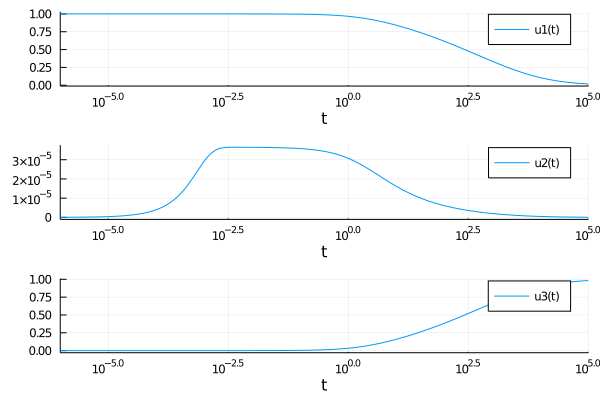

In [223]:
using DifferentialEquations, Plots
function rober(du,u,p,t)
  y₁,y₂,y₃ = u
  k₁,k₂,k₃ = p
  du[1] = -k₁*y₁+k₃*y₂*y₃
  du[3] =  k₂*y₂^2
  du[2] =  -du[1] - du[3]
  nothing
end

f = ODEFunction(rober)
prob_mm = ODEProblem(f,[1.0,0.0,0.0],(0.0,1e5),(0.04,3e7,1e4))
sol = solve(prob_mm,Rosenbrock23())

plot(sol, xscale=:log10, tspan=(1e-6, 1e5), layout=(3,1))